## Commented code for CNN

In [140]:
#import cell for libraries

#default computation libraries
import sklearn
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

#display and grahps libraries
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

#ML / NN libraries
from tensorflow import keras
from tensorflow.keras import layers


#miscellaneous libraries
import gc
import time

#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
#from keras.utils import to_categorical
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#from keras import initializers, regularizers
#from keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import confusion_matrix


def CNNDefinition(fil, k_size,  Poolsize, dense, 
                  input_shape, N_categ ,  loss = 'categorical_crossentropy',  
                  metrics = ['accuracy'], last_act = "sigmoid" ):
    """
    This CNNDefinition function allows the definition of a CNN network. The Network defined can be exploited for both 
    a regression and for a classification task.
    
    (1D NETWORK ARE THERE BY DEFINITION - I THINK WE'LL HAVE TO USE CONV3D LAYERS)
    Parameters ---
    fil : list of the number of filters per each convolutional layer,
    k_size : dimension of the kernels related to each convolutional layer,
    Poolsize : dimension of the pooling layer applied after each convolutional one,
    dense : list of dimensions of dense layers applied after the convolutional step, 
    input_shape :  dimension of the input data , 
    N_categ : number of categories in the classification task (has to be set at 1 for regression),
    loss = 'categorical_crossentropy',  
    metrics = ['accuracy'], 
    last_act : default = "sigmoid", ok for classification. Has to be changed for regression
    """
    model = keras.Sequential()    
    model.add(layers.Conv1D(filters = fil[0], kernel_size = k_size[0],
                            padding = "same",
                            activation = "relu",
                            input_shape = [input_shape, 1]
                            ))
    model.add(layers.MaxPooling1D(Poolsize[0]))

    for i in range(1,len(fil)):
        model.add(layers.Conv1D(filters = fil[i], kernel_size = k_size[i],
                                padding = "same", activation = "relu"))
        model.add(layers.MaxPooling1D(Poolsize[i]))

    model.add(layers.Flatten())
    for i in range(len(dense)):
        model.add(layers.Dense(dense[i],activation="relu"))

    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(N_categ, activation= last_act ))

    print(model.summary())

    #default optimizer is Adam, different learning rates affect the time the network takes to converge.
    optimizer = keras.optimizers.Adam(0.001)
    optimizer.learning_rate.assign(0.01)

    model.compile(
        optimizer = optimizer, 
        loss = loss, 
        metrics = metrics
    )

    return model



def Fit(model, X_train, Y_train, X_test, Y_test, pat = 100, mindelta = 0.01, batch = 64, epochs = 1200, verb = 1):
    
    '''
    Fit function for fitting the model. Training and test data are specified as parameters; 
    EarlyStopping is introduced to avoid overfitting.
    The function returns a dataframe containing the history of the training. The values of the accuracy and the different 
    epochs can be then inferred from such a returned quantity.
    
    Parameters ---
    model : model to be fit,
    X_train : train features,
    Y_train : train targets,
    X_test : test features,
    Y_test : test features,
    pat : default = 100, patience for the EarlyStopping, 
    mindelta : default = 0.01, mindelta in EarlyStopping, 
    batch : default = 64, batch size while fitting, 
    epochs : default = 1200, number of epochs for training,  
    verb = 1):
    '''

    early_stopping = keras.callbacks.EarlyStopping(
        patience = pat,
        min_delta = mindelta,
        restore_best_weights=True,
    )

    history = model.fit(
        X_train, Y_train,
        validation_data=(X_test, Y_test),
        batch_size = batch,
        epochs = epochs,
        callbacks=[early_stopping],
        verbose=verb, # hide the output because we have so many epochs
    )

    return pd.DataFrame(history.history)

In [ ]:
path_to_file = '../Files/SIM_Z92_A239_5MeV.root'

...load_data...
X_train,  y_train_keras, X_test, y_test_keras = split load data in train and test...


In [ ]:
l_fil = [128, 64, 32]
l_ker = [10, 5, 3]
l_pol = [5, 5, 5]
l_dense = [50, 50]
model_cv_invk = CNNDefinition(l_fil, l_ker, l_pol, l_dense, X_train.shape[-1], y_train_keras.shape[-1])

In [ ]:
#FOR CNN, the shape of the train data has to have three dimensions - this simple reshape is paramount!!!
#(GICA - SHOULD NOT BE NEEDED IN OUR CASE)
# X_train_cn = X_train.reshape(X_train.shape[0] ,X_train.shape[1],1)
# X_test_cn = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

#fitting the model with default parameters
history_cnn_invk_df = Fit(model_cv_invk, X_train_cn, y_train_keras, X_test_cn, y_test_keras)

In [ ]:
#comparing predictions from the model and the simulated data
preds = model_cv_invk.predict(X_test_cn)
class_preds = np.argmax(preds, axis=-1) 

true_preds = np.argmax(y_test_keras, axis=-1)

#printing the histogram of simulations vs predictions
bins = range(0, 35)
plt.hist(true_preds, alpha = 0.5, bins = bins)
plt.hist(class_preds, alpha = 0.5, bins = bins)
plt.show()

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
def array_to_color(array, cmap="Oranges"):
    s_m = plt.cm.ScalarMappable(cmap=cmap)
    return s_m.to_rgba(array)[:,:-1]


def rgb_data_transform(data):
    data_t = []
    for i in range(data.shape[0]):
        data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))
    return np.asarray(data_t, dtype=np.float32)

In [ ]:
with h5py.File("./full_dataset_vectors.h5", "r") as hf:    

    # Split the data into training/test features/targets
    X_train = hf["X_train"][:]
    targets_train = hf["y_train"][:]
    X_test = hf["X_test"][:] 
    targets_test = hf["y_test"][:]

    # Determine sample shape
    sample_shape = (16, 16, 16, 3)

    # Reshape data into 3D format
    X_train = rgb_data_transform(X_train)
    X_test = rgb_data_transform(X_test)

    # Convert target vectors to categorical targets
    targets_train = to_categorical(targets_train).astype(np.integer)
    targets_test = to_categorical(targets_test).astype(np.integer)

In [ ]:
# Create the model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()
# Fit data to model
history = model.fit(X_train, targets_train,
            batch_size=128,
            epochs=40,
            verbose=1,
            validation_split=0.3)

In [ ]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

In [ ]:
# dataset representation
[n_images,224,224,3]  #tensor

input_ = [224,224,3] #224*224 pixels * RGB channels

CONV #convolutional operation
RELU #activation (keep dimensions of CONV)

POOL #reduces dimensionality

FC #output layer, will be a [1,1,325]

### Read the dataset of images and get the inputs and targets ready!

In [71]:
def get_path(Id,df):
    """Input: row number of the dataframe
       Returns the filepath for the corresponding image"""
    
    #get path from dataframe
    path2 = df.loc[Id]["filepaths"]
    
    #return the path
    return path2

def get_image(Id,df,x=224,y=224):
    """Returns image of a given row of the birds dataframe"""
    #get initial path to all data
    path1 = "Data/"
    
    #call fet_path function
    path2 = get_path(Id,df)
    
    #read image of the path1+path2 and return it
    return Image.open(path1+path2).resize((x,y), Image.ANTIALIAS)

def get_input_NN(Id,df,x=224,y=224,gray = False):
    """Return a 3D matrix of image ready to be read in the CNN"""
    
    #call fet_image function to read image
    im = get_image(Id,df,x,y)
    
    #transform iamge to RGB format
    rgb_im = im.convert('RGB')
    
    if gray:
        g_im = rgb_im.convert('L')
        input_NN = asarray(g_im)
                
    else:
    
        #Empty zeros matrix to be filled with pixel values of the image
        input_NN = np.zeros((3,x,y))

        #fill up the matrix with RGB values at each point
        for xx in range(x):
            for yy in range(y):
                r, g, b = rgb_im.getpixel((xx,yy))
                input_NN[0,xx,yy] = r
                input_NN[1,xx,yy] = g
                input_NN[2,xx,yy] = b

    #returns the 3D matrix a s a numpy array
    return input_NN


def show_image(Id,inputs,gray = False):
    """Print image from Id of image in the input array"""
    if gray:
        im = plt.imshow(inputs[Id], cmap = "gray")
    else:
        im = plt.imshow(inputs[Id].astype('uint8'))
    


import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from tqdm import tqdm
import pickle

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
#from tensorflow.keras import Conv2D
#from tensorflow.keras import MaxPooling2D
#from tensorflow.keras import Flatten

from sklearn.model_selection import train_test_split
from numpy import asarray



def get_class_dict():
    """Return dictionary of classes of each target"""

    class_dict_df = pd.read_csv("Data/class_dict.csv")
    class_dict = {}
    for row in range(len(class_dict_df)):
        class_dict[class_dict_df.iloc[row][1]] = class_dict_df.iloc[row][0]
    return class_dict

In [72]:
birds = pd.read_csv("Data/birds.csv")

label_list = list(birds.labels.unique())
sub_label_list = label_list[0:20]
birds_20 = birds[birds["labels"].isin(sub_label_list)]

train_20 = birds_20[birds_20["data set"] == "train"]
# test_20 = birds_20[birds_20["data set"] == "test"]
# valid_20 = birds_20[birds_20["data set"] == "valid"]

In [74]:
import random

In [242]:
def get_image(Id,df,x=224,y=224):
    """Returns image of a given row of the birds dataframe"""
    #get initial path to all data
    path1 = "Data/"
    
    #call fet_path function
    path2 = get_path(Id,df)
    
    #read image of the path1+path2 and return it
    im= Image.open(path1+path2).resize((x,y), Image.ANTIALIAS)
    return im


In [255]:
ids = [2400,76,2475]
x = 224
y = 224
inputs = np.zeros([3,x,y])

for n, Id in enumerate(ids):
    inputs[n] = get_input_NN(Id,train_20,x,y,gray = False)

ValueError: could not broadcast input array from shape (3,224,224) into shape (224,224)

In [256]:
b = get_input_NN(76,train_20,x,y,gray = False)
c = get_input_NN(2475,train_20,x,y,gray = False)

In [288]:
x = 224
y = 224
a = get_input_NN(2475,train_20,x,y,gray = False)
x = 56
y = 56
a_1 = get_input_NN(2475,train_20,x,y,gray = False)
a_2 = get_input_NN(2475,train_20,x,y,gray = True)



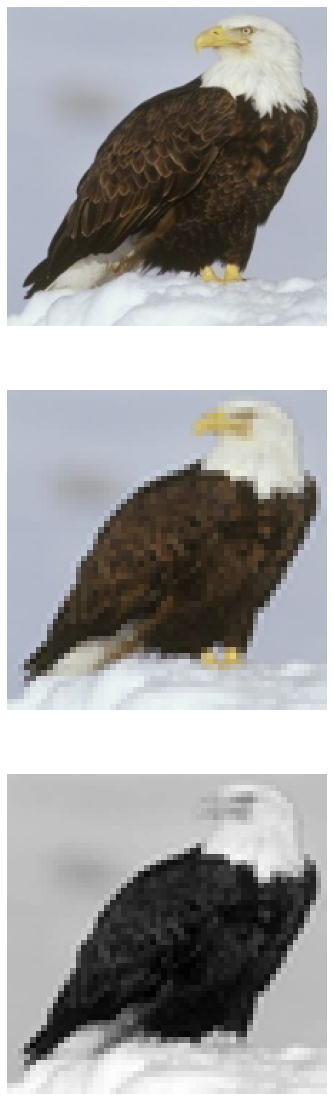

In [291]:
images = [a, a_1, a_2] 
plt.figure(figsize=(10,20))
for i in range(3):
    plt.subplot(3,1,i+1)
    if i != 2:
        plt.imshow(images[i].T.astype('uint8'))
        plt.axis('off')
    else:
        plt.imshow(images[i], cmap = "gray")
        plt.axis('off')

plt.savefig("figures/resolution_comparison___1.jpg")        
plt.show()

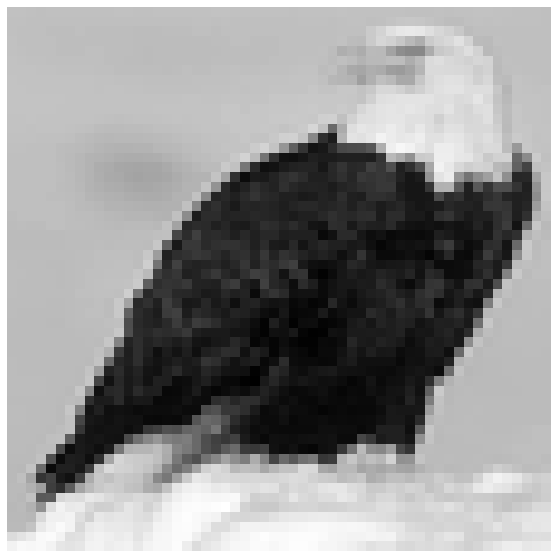

In [295]:
images = [a, a_1, a_2] 
plt.figure(figsize=(10,10))
# plt.imshow(images[1].T.astype('uint8'))
plt.axis('off')
plt.imshow(images[2], cmap = "gray")
plt.savefig("figures/resolution_comparison___1_3.jpg")        
plt.show()

In [249]:
a.shape

(3, 224, 224)

In [253]:
inputs = np.zeros((3,x,y))
inputs.shape

(3, 224, 224)

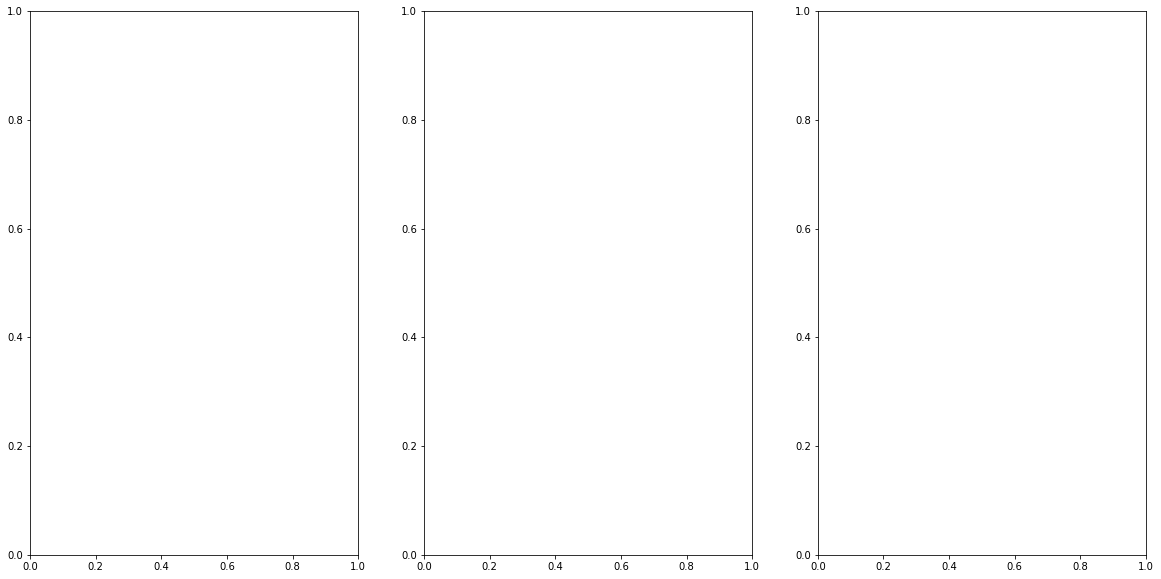

In [244]:
# plt.figure(figsize=(20,10))
# plt.subplot(131)
# im = get_image(2400,train_20,x=224,y=224)
# plt.subplot(132)
# im = get_image(76,train_20,x=224,y=224)
# plt.subplot(133)
# im = get_image(2475,train_20,x=224,y=224)

ids = [2400,76,2475]


plt.figure(figsize=(20,10))
for i, Id in enumerate(ids):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    show_image(Id,train_20,gray=True)
    plt.title(f"{birds_20.loc[Id][1]}")
plt.show()


2475


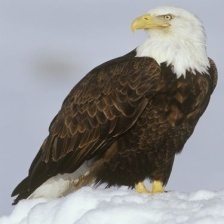

In [239]:
n = random.randint(0,len(train_20))
print(n)
get_image(n,train_20,x=224,y=224)
# input_NN = get_input_NN(random.randint(0,len(train_20)),train_20,x,y,gray = True)

#### Subselect of 20 birds

In [4]:
train_20.shape

(2987, 3)

### Compute Inputs

In [70]:
x = 56
y = 56

inputs = np.zeros((len(train_20),x,y))
key_list = list(train_20.index)
n = 0
for Id in tqdm(key_list):
    input_NN = get_input_NN(Id,train_20,x,y,gray = True)
    inputs[n] = input_NN
    n+=1

  0%|                                                                                         | 0/2987 [00:00<?, ?it/s]


ValueError: could not broadcast input array from shape (56,56) into shape (56,1)

In [61]:
# a_file = open("inputs_56_56_gray.pkl", "wb")
# pickle.dump(inputs, a_file)
# a_file.close()

## Load!!

In [62]:
a_file = open("inputs_56_56_gray.pkl", "rb")
inputs_trial = pickle.load(a_file)

In [ ]:
#Moretn CNN 

In [63]:
# import necessary packages
print("inputs = (n_inputs, pixel_width, pixel_height, depth) = " + str(inputs_trial.shape))

inputs = (n_inputs, pixel_width, pixel_height, depth) = (2987, 56, 56)


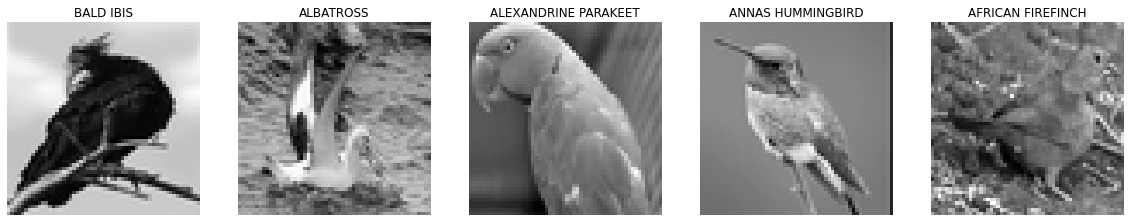

In [68]:
# choose some random images to display
n_inputs = len(inputs_trial)
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)


plt.figure(figsize=(20,10))
for i, Id in enumerate(random_indices):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    show_image(Id,inputs_trial,gray=True)
    plt.title(f"{birds_20.loc[Id][1]}")
plt.show()

In [25]:
birds_100 #.loc[Id][1]

,filepaths,labels,data set
0,train/AFRICAN CROWNED CRANE/001.jpg,AFRICAN CROWNED CRANE,train
1,train/AFRICAN CROWNED CRANE/002.jpg,AFRICAN CROWNED CRANE,train
2,train/AFRICAN CROWNED CRANE/003.jpg,AFRICAN CROWNED CRANE,train
3,train/AFRICAN CROWNED CRANE/004.jpg,AFRICAN CROWNED CRANE,train
4,train/AFRICAN CROWNED CRANE/005.jpg,AFRICAN CROWNED CRANE,train
...,...,...,...
49452,valid/D-ARNAUDS BARBET/1.jpg,D-ARNAUDS BARBET,valid
49453,valid/D-ARNAUDS BARBET/2.jpg,D-ARNAUDS BARBET,valid
49454,valid/D-ARNAUDS BARBET/3.jpg,D-ARNAUDS BARBET,valid
49455,valid/D-ARNAUDS BARBET/4.jpg,D-ARNAUDS BARBET,valid


In [28]:
class_dict = get_class_dict()
labels = np.zeros((2987))
for label in range(len(train_20)):
    labels[label] = class_dict[train_20.iloc[label][1]]

In [30]:
labels
inputs = inputs_trial

array([ 0.,  0.,  0., ..., 19., 19., 19.])

In [56]:
# split into train and test data
# one-liner from scikit-learn library
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels,  train_size=train_size,
                                                    test_size=test_size)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

NameError: name 'keras' is not defined

In [62]:
def create_convolutional_neural_network_keras(input_shape, receptive_field,
                                              n_filters, n_neurons_connected, n_categories,
                                              eta, lmbd):
    model = Sequential()
    model.add(layers.Conv2D(n_filters, (receptive_field, receptive_field), input_shape=input_shape, padding='same',
              activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(n_neurons_connected, activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(layers.Dense(n_categories, activation='softmax', kernel_regularizer=regularizers.l2(lmbd)))
    
    sgd = optimizers.SGD(lr=eta)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model


epochs = 100
batch_size = 100
input_shape = X_train.shape[1:4]
receptive_field = 3
n_filters = 10
n_neurons_connected = 50
n_categories = 325

eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)

In [38]:
input_shape = inputs[0].shape
input_shape

(224, 224, 3)

In [63]:
model = Sequential()
model.add(layers.Conv2D(12, (10, 10), input_shape =input_shape , padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(5, 5)))
model.add(layers.Conv2D(12, (10, 10), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(5, 5)))
model.add(layers.Flatten())
#model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))

sgd = optimizers.SGD(lr=1)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 224, 224, 12)      3612      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 44, 44, 12)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 44, 44, 12)        14412     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 12)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 768)               0         
                                                                 
 dense_13 (Dense)            (None, 20)               

In [64]:
model.fit(X_train, Y_train, epochs=50, batch_size=128, validation_data=(X_test, Y_test))
# scores = model.evaluate(X_test, Y_test)       
# print("Test accuracy: %.3f" % scores[1])

Epoch 1/50
11/19 [================>.............] - ETA: 1:36 - loss: 45377724416.0000 - accuracy: 0.0526

KeyboardInterrupt: 

In [54]:
Y_train.shape


(2389,)

In [34]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))